# Using Label Studio for Annotations with Pixeltable

This tutorial demonstrates how to integrate Pixeltable with Label Studio, in order to provide seamless management of annotations data across the annotation workflow. We'll assume that you're at least somewhat familiar with Pixeltable and have read the [10-Minute Tour](https://docs.pixeltable.com/overview/ten-minute-tour) tutorial.

__This tutorial can only be run in a local Pixeltable installation, not in Colab or Kaggle__, since it relies on spinning up a locally running Label Studio instance. See the [Quick Start](https://docs.pixeltable.com/overview/quick-start) guide for instructions on how to set up a local Pixeltable instance.

To begin, let's ensure the requisite dependencies are installed.

In [ ]:
%pip install -qU pixeltable label-studio label-studio-sdk torch transformers

## Set up Label Studio

Now let's spin up a Label Studio server process. (If you're already running Label Studio, you can choose to skip this step, and instead enter your existing Label Studio URL and access token in the subsequent step.) Be patient, as it may take a minute or two to start.

This will open a new browser window containing the Label Studio interface. If you've never run Label Studio before, you'll need to create an account; a link to create one will appear in the Label Studio browser window. __Everything is running locally in this tutorial, so the account will exist only on your local system.__

In [1]:
import subprocess

ls_process = subprocess.Popen(['label-studio'], stderr=subprocess.PIPE)

January 23, 2026 - 01:41:50
Django version 5.1.15, using settings 'label_studio.core.settings.label_studio'
Starting development server at http://0.0.0.0:8080/
Quit the server with CONTROL-C.



If for some reason the Label Studio browser window failed to open, you can always access it at: http://localhost:8080/

Once you've created an account in Label Studio, you'll need to locate your API key. In the Label Studio browser window, log in, click "Organization", "API Tokens Settings", and enable "Legacy Tokens". Then click on "Account & Settings" in the top right, click "Legacy Token", and copy the Access Token from the interface.

## Configure Pixeltable

Next, we configure Pixeltable to communicate with Label Studio. Run the following command, pasting in the API key that you copied from the Label Studio interface.

In [ ]:
import getpass
import os

if 'LABEL_STUDIO_URL' not in os.environ:
    os.environ['LABEL_STUDIO_URL'] = 'http://localhost:8080/'

if 'LABEL_STUDIO_API_KEY' not in os.environ:
    os.environ['LABEL_STUDIO_API_KEY'] = getpass.getpass(
        'Label Studio API key: '
    )

## Create a Table to Store Videos

Now we create the master table that will hold our videos to be annotated. This only needs to be done once, when we initially set up the workflow.

In [2]:
import pixeltable as pxt

schema = {'video': pxt.Video, 'date': pxt.Timestamp}

# Before creating the table, we drop the `ls_demo` dir and all its contents,
# in order to ensure a clean environment for the demo.
pxt.drop_dir('ls_demo', force=True)
pxt.create_dir('ls_demo')
videos_table = pxt.create_table('ls_demo/videos', schema)

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/asiegel/.pixeltable/pgdata
Created directory 'ls_demo'.
Created table 'videos'.


## Populate It with Data

Now let's add some videos to the table to populate it. For this tutorial, we'll use some randomly selected videos from the Multimedia Commons archive. The table also contains a `date` field, for which we'll use a fixed date (but in a production setting, it would typically be the date on which the video was imported).

In [3]:
from datetime import datetime

url_prefix = 'http://multimedia-commons.s3-website-us-west-2.amazonaws.com/data/videos/mp4/'
files = [
    '122/8ff/1228ff94bf742242ee7c88e4769ad5d5.mp4',
    '2cf/a20/2cfa205eae979b31b1144abd9fa4e521.mp4',
    'ffe/ff3/ffeff3c6bf57504e7a6cecaff6aefbc9.mp4',
]
today = datetime(2024, 4, 22)
videos_table.insert(
    {'video': url_prefix + file, 'date': today} for file in files
)

Inserted 3 rows with 0 errors in 1.07 s (2.81 rows/s)


3 rows inserted.

Let's have a look at the table now.

video,date
,2024-04-22 00:00:00-07:00
,2024-04-22 00:00:00-07:00
,2024-04-22 00:00:00-07:00

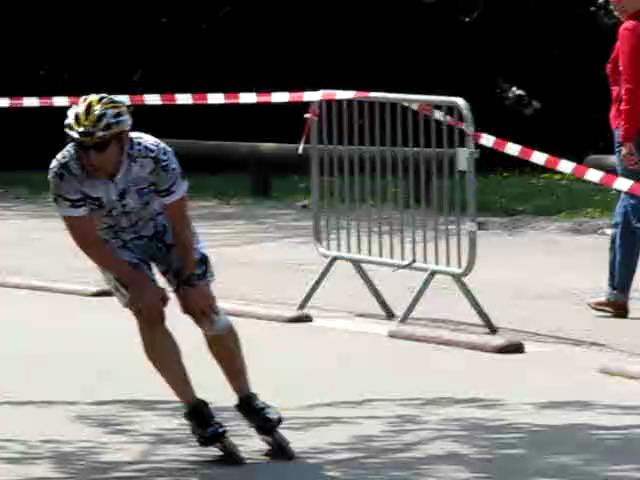
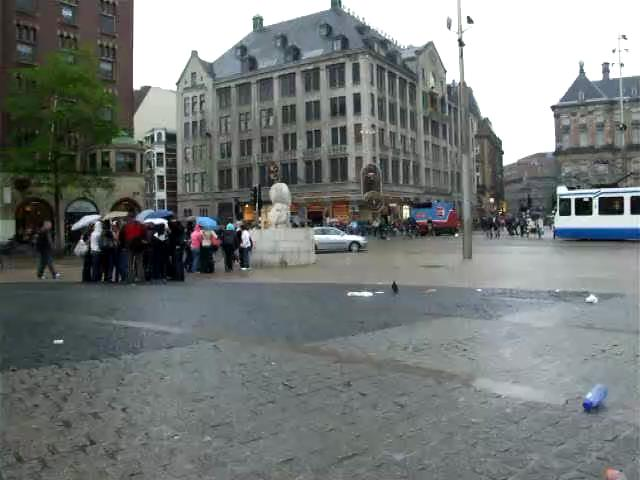
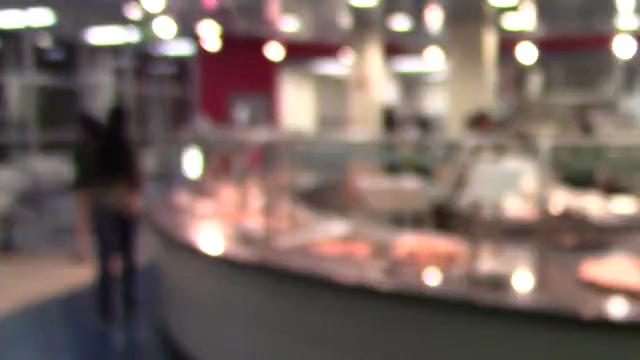

In [4]:
videos_table.head()

## Create a Label Studio project

Next we'll create a new Label Studio project and link it to a new view on the Pixeltable table. You can link a Label Studio project to either a table or a view. For tables that are expecting a lot of input data, it's often easier to link to views. In this example, we'll create a view that filters the table down by date.

In [5]:
# Create a view to filter on the specified date

v = pxt.create_view(
    'ls_demo/videos_2024_04_22',
    videos_table.where(videos_table.date == today),
)

# Create a new Label Studio project and link it to the view. The
# configuration uses Label Studio's standard XML format. This only
# needs to be done once: after the view and project are linked,
# the relationship is stored indefinitely in Pixeltable's metadata.

label_config = """
    <View>
      <Video name="video" value="$video"/>
      <Choices name="video-category" toName="video" showInLine="true">
        <Choice value="city"/>
        <Choice value="food"/>
        <Choice value="sports"/>
      </Choices>
    </View>
    """

pxt.io.create_label_studio_project(v, label_config)

Added 3 column values with 0 errors in 0.01 s (355.10 rows/s)
Added 3 column values with 0 errors in 0.02 s (146.19 rows/s)
Linked external store 'ls_project_0' to table 'videos_2024_04_22'.
Created 3 new task(s) in LabelStudioProject `videos_2024_04_22`.


No rows affected.

If you look in the Label Studio UI now, you'll see that there's a new project with the name `videos_2022_04_22`, with three tasks, one for each of the videos in the view. If you want to create the project without populating it with tasks (yet), you can set `sync_immediately=False` in the call to `create_label_studio_project()`. You can always sync the table and project by calling `v.sync()`.

Note also that we didn't have to specify an explicit mapping between Pixeltable columns and Label Studio data fields. This is because, by default, Pixeltable assumes the Pixeltable and Label Studio field names coincide. The data field in the Label Studio project has the name `$video`, which Pixeltable maps, by default, to the column in `ls_demo.videos_2024_02_22` that is also called `video`. If you want to override this behavior to specify an explicit mapping of columns to fields, you can do that with the `col_mapping` parameter of `create_label_studio_project()`.

Inspecting the view, we also see that Pixeltable created an additional column on the view, `annotations`, which will hold the output of our annotations workflow. The name of the output column can also be overridden by specifying a dict entry in `col_mapping` of the form `{'my_col_name': 'annotations'}`.

In [6]:
v

view 'ls_demo/videos_2024_04_22' (of 'ls_demo/videos')
Where: date == '2024-04-22T00:00:00-07:00'

  Column Name       Type Computed With
  annotations       Json              
        video      Video              
         date  Timestamp              

 External Store                Type
   ls_project_0  LabelStudioProject

## Add Some Annotations

Now, let's add some annotations to our Label Studio project to simulate a human-in-the-loop workflow. In the Label Studio UI, click on the new `videos_2024_02_22` project, and click on any of the three tasks. Select the appropriate category ("city", "food", or "sports"), and click "Submit".

## Import the Annotations Back To Pixeltable

Now let's try importing annotations from Label Studio back to our view.

In [7]:
v = pxt.get_table('ls_demo/videos_2024_04_22')
v.sync()

Created 0 new task(s) in LabelStudioProject `videos_2024_04_22`.
Updated annotation(s) from 3 task(s) in LabelStudioProject `videos_2024_04_22`.


3 rows updated.

Let's see what effect that had. You'll see that any videos that you annotated now have their `annotations` field populated in the view.

video,annotations
,"[{""id"": 35, ""task"": 169, ""result"": [{""id"": ""k6GF6V0KFJ"", ""type"": ""choices"", ""value"": {""choices"": [""sports""]}, ""origin"": ""manual"", ""to_name"": ""video"", ""from_name"": ""video-category""}], ""project"": 110, ""import_id"": null, ""lead_time"": 6.07, ""created_at"": ""2026-01-23T01:43:59.187846Z"", ""updated_at"": ""2026-01-23T01:43:59.187855Z"", ""updated_by"": 2, ""created_ago"": ""0\u00a0minutes"", ""last_action"": null, ""bulk_created"": false, ""completed_by"": 2, ""ground_truth"": false, ""was_cancelled"": false, ""last_created_by"": null, ""created_username"": "" asiegel@pixeltable.com, 2"", ""draft_created_at"": null, ""parent_annotation"": null, ""parent_prediction"": null}]"
,"[{""id"": 36, ""task"": 170, ""result"": [{""id"": ""X_w04Rm_Sv"", ""type"": ""choices"", ""value"": {""choices"": [""city""]}, ""origin"": ""manual"", ""to_name"": ""video"", ""from_name"": ""video-category""}], ""project"": 110, ""import_id"": null, ""lead_time"": 2.891, ""created_at"": ""2026-01-23T01:44:05.853116Z"", ""updated_at"": ""2026-01-23T01:44:05.853126Z"", ""updated_by"": 2, ""created_ago"": ""0\u00a0minutes"", ""last_action"": null, ""bulk_created"": false, ""completed_by"": 2, ""ground_truth"": false, ""was_cancelled"": false, ""last_created_by"": null, ""created_username"": "" asiegel@pixeltable.com, 2"", ""draft_created_at"": null, ""parent_annotation"": null, ""parent_prediction"": null}]"
,"[{""id"": 37, ""task"": 171, ""result"": [{""id"": ""KkX9buDYor"", ""type"": ""choices"", ""value"": {""choices"": [""food""]}, ""origin"": ""manual"", ""to_name"": ""video"", ""from_name"": ""video-category""}], ""project"": 110, ""import_id"": null, ""lead_time"": 3.302, ""created_at"": ""2026-01-23T01:44:10.621907Z"", ""updated_at"": ""2026-01-23T01:44:10.621916Z"", ""updated_by"": 2, ""created_ago"": ""0\u00a0minutes"", ""last_action"": null, ""bulk_created"": false, ""completed_by"": 2, ""ground_truth"": false, ""was_cancelled"": false, ""last_created_by"": null, ""created_username"": "" asiegel@pixeltable.com, 2"", ""draft_created_at"": null, ""parent_annotation"": null, ""parent_prediction"": null}]"

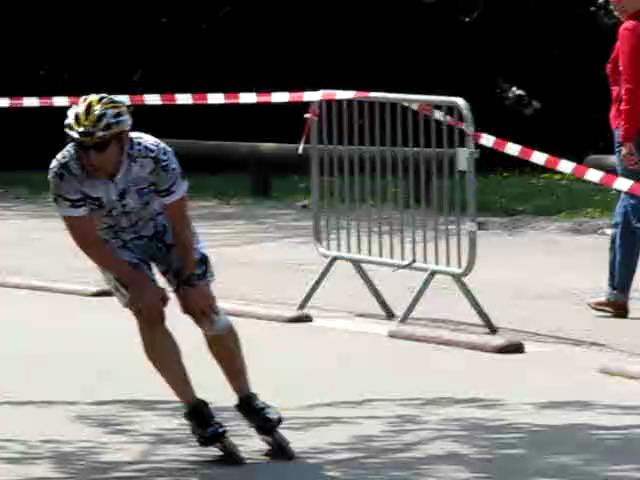
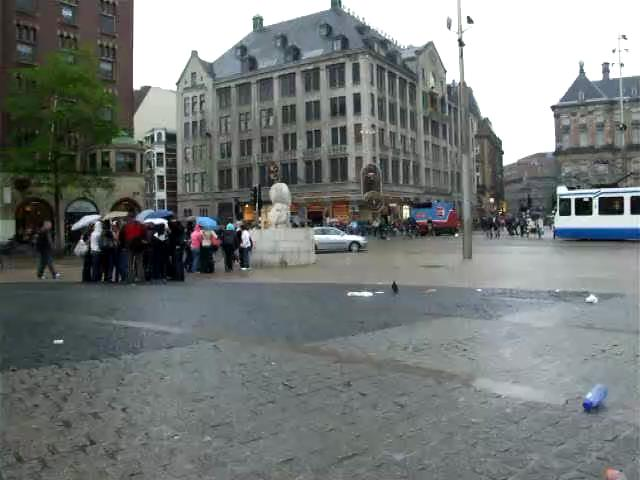
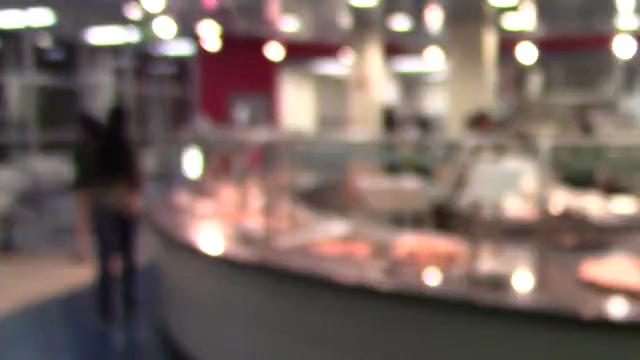

In [8]:
v.select(v.video, v.annotations).head()

## Parse Annotations with a Computed Column

Pixeltable pulls in all sorts of metadata from Label Studio during a sync: everything that Label Studio reports back about the annotations, including things like the user account that created the annotations. Let's say that all we care about is the annotation value. We can add a computed column to our table to pull it out.

Added 3 column values with 0 errors in 0.02 s (143.55 rows/s)


video,annotations,video_category
,"[{""id"": 35, ""task"": 169, ""result"": [{""id"": ""k6GF6V0KFJ"", ""type"": ""choices"", ""value"": {""choices"": [""sports""]}, ""origin"": ""manual"", ""to_name"": ""video"", ""from_name"": ""video-category""}], ""project"": 110, ""import_id"": null, ""lead_time"": 6.07, ""created_at"": ""2026-01-23T01:43:59.187846Z"", ""updated_at"": ""2026-01-23T01:43:59.187855Z"", ""updated_by"": 2, ""created_ago"": ""0\u00a0minutes"", ""last_action"": null, ""bulk_created"": false, ""completed_by"": 2, ""ground_truth"": false, ""was_cancelled"": false, ""last_created_by"": null, ""created_username"": "" asiegel@pixeltable.com, 2"", ""draft_created_at"": null, ""parent_annotation"": null, ""parent_prediction"": null}]",sports
,"[{""id"": 36, ""task"": 170, ""result"": [{""id"": ""X_w04Rm_Sv"", ""type"": ""choices"", ""value"": {""choices"": [""city""]}, ""origin"": ""manual"", ""to_name"": ""video"", ""from_name"": ""video-category""}], ""project"": 110, ""import_id"": null, ""lead_time"": 2.891, ""created_at"": ""2026-01-23T01:44:05.853116Z"", ""updated_at"": ""2026-01-23T01:44:05.853126Z"", ""updated_by"": 2, ""created_ago"": ""0\u00a0minutes"", ""last_action"": null, ""bulk_created"": false, ""completed_by"": 2, ""ground_truth"": false, ""was_cancelled"": false, ""last_created_by"": null, ""created_username"": "" asiegel@pixeltable.com, 2"", ""draft_created_at"": null, ""parent_annotation"": null, ""parent_prediction"": null}]",city
,"[{""id"": 37, ""task"": 171, ""result"": [{""id"": ""KkX9buDYor"", ""type"": ""choices"", ""value"": {""choices"": [""food""]}, ""origin"": ""manual"", ""to_name"": ""video"", ""from_name"": ""video-category""}], ""project"": 110, ""import_id"": null, ""lead_time"": 3.302, ""created_at"": ""2026-01-23T01:44:10.621907Z"", ""updated_at"": ""2026-01-23T01:44:10.621916Z"", ""updated_by"": 2, ""created_ago"": ""0\u00a0minutes"", ""last_action"": null, ""bulk_created"": false, ""completed_by"": 2, ""ground_truth"": false, ""was_cancelled"": false, ""last_created_by"": null, ""created_username"": "" asiegel@pixeltable.com, 2"", ""draft_created_at"": null, ""parent_annotation"": null, ""parent_prediction"": null}]",food

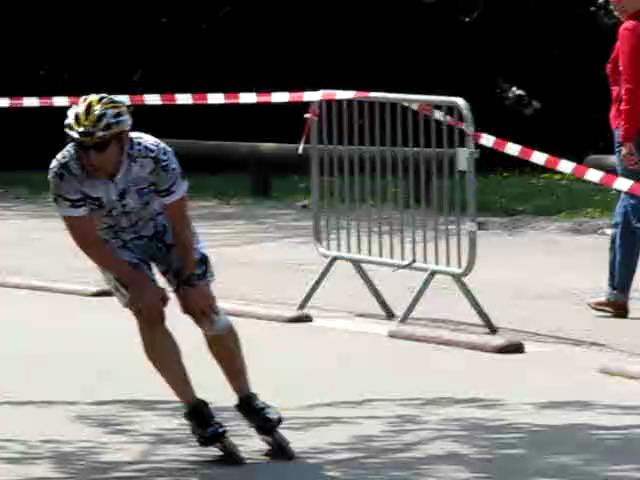
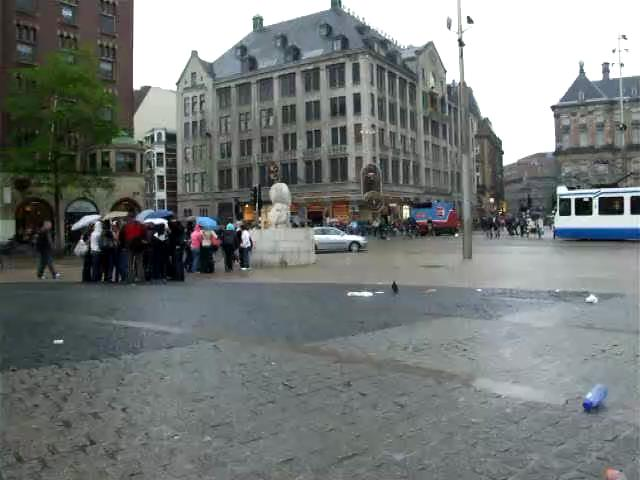
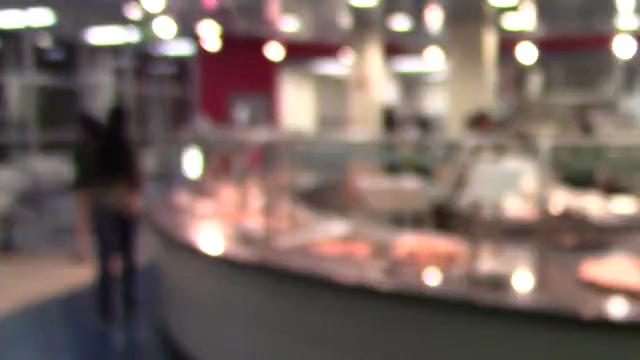

In [9]:
v.add_computed_column(
    video_category=v.annotations[0].result[0].value.choices[0]
)
v.select(v.video, v.annotations, v.video_category).head()

Another useful operation is the `get_metadata` function, which returns information about the video itself, such as the resolution and codec (independent of Label Studio). Let's add another computed column to hold such metadata.

Added 3 column values with 0 errors in 0.03 s (115.36 rows/s)


video,annotations,video_category,video_metadata
,"[{""id"": 35, ""task"": 169, ""result"": [{""id"": ""k6GF6V0KFJ"", ""type"": ""choices"", ""value"": {""choices"": [""sports""]}, ""origin"": ""manual"", ""to_name"": ""video"", ""from_name"": ""video-category""}], ""project"": 110, ""import_id"": null, ""lead_time"": 6.07, ""created_at"": ""2026-01-23T01:43:59.187846Z"", ""updated_at"": ""2026-01-23T01:43:59.187855Z"", ""updated_by"": 2, ""created_ago"": ""0\u00a0minutes"", ""last_action"": null, ""bulk_created"": false, ""completed_by"": 2, ""ground_truth"": false, ""was_cancelled"": false, ""last_created_by"": null, ""created_username"": "" asiegel@pixeltable.com, 2"", ""draft_created_at"": null, ""parent_annotation"": null, ""parent_prediction"": null}]",sports,"{""size"": 815026, ""streams"": [{""type"": ""video"", ""width"": 640, ""frames"": 235, ""height"": 480, ""duration"": 235235, ""metadata"": {""encoder"": ""AVC Coding"", ""language"": ""eng"", ""vendor_id"": ""[0][0][0][0]"", ""handler_name"": ""MP4 Video Media Handler"", ""creation_time"": ""2010-04-27T16:40:32.000000Z""}, ""base_rate"": 29.97, ""time_base"": 3.333e-05, ""average_rate"": 29.97, ""guessed_rate"": 29.97, ""codec_context"": {""name"": ""h264"", ""pix_fmt"": ""yuv420p"", ""profile"": ""High"", ""codec_tag"": ""avc1""}, ""duration_seconds"": 7.841}, {""type"": ""audio"", ""frames"": 339, ""duration"": 347135, ""metadata"": {""language"": ""eng"", ""vendor_id"": ""[0][0][0][0]"", ""handler_name"": ""MP4 Sound Media Handler"", ""creation_time"": ""2010-04-27T16:40:32.000000Z""}, ""time_base"": 2.268e-05, ""codec_context"": {""name"": ""aac"", ""profile"": ""LC"", ""channels"": 2, ""codec_tag"": ""mp4a""}, ""duration_seconds"": 7.872}], ""bit_rate"": 828326, ""metadata"": {""major_brand"": ""mp42"", ""creation_time"": ""2010-04-27T16:40:32.000000Z"", ""minor_version"": ""0"", ""compatible_brands"": ""isom""}, ""bit_exact"": false}"
,"[{""id"": 36, ""task"": 170, ""result"": [{""id"": ""X_w04Rm_Sv"", ""type"": ""choices"", ""value"": {""choices"": [""city""]}, ""origin"": ""manual"", ""to_name"": ""video"", ""from_name"": ""video-category""}], ""project"": 110, ""import_id"": null, ""lead_time"": 2.891, ""created_at"": ""2026-01-23T01:44:05.853116Z"", ""updated_at"": ""2026-01-23T01:44:05.853126Z"", ""updated_by"": 2, ""created_ago"": ""0\u00a0minutes"", ""last_action"": null, ""bulk_created"": false, ""completed_by"": 2, ""ground_truth"": false, ""was_cancelled"": false, ""last_created_by"": null, ""created_username"": "" asiegel@pixeltable.com, 2"", ""draft_created_at"": null, ""parent_annotation"": null, ""parent_prediction"": null}]",city,"{""size"": 1558736, ""streams"": [{""type"": ""video"", ""width"": 640, ""frames"": 450, ""height"": 480, ""duration"": 450450, ""metadata"": {""encoder"": ""AVC Coding"", ""language"": ""eng"", ""vendor_id"": ""[0][0][0][0]"", ""handler_name"": ""MP4 Video Media Handler"", ""creation_time"": ""2009-05-20T00:53:00.000000Z""}, ""base_rate"": 29.97, ""time_base"": 3.333e-05, ""average_rate"": 29.97, ""guessed_rate"": 29.97, ""codec_context"": {""name"": ""h264"", ""pix_fmt"": ""yuv420p"", ""profile"": ""High"", ""codec_tag"": ""avc1""}, ""duration_seconds"": 15.015}, {""type"": ""audio"", ""frames"": 648, ""duration"": 663551, ""metadata"": {""language"": ""eng"", ""vendor_id"": ""[0][0][0][0]"", ""handler_name"": ""MP4 Sound Media Handler"", ""creation_time"": ""2009-05-20T00:53:00.000000Z""}, ""time_base"": 2.268e-05, ""codec_context"": {""name"": ""aac"", ""profile"": ""LC"", ""channels"": 2, ""codec_tag"": ""mp4a""}, ""duration_seconds"": 15.047}], ""bit_rate"": 828756, ""metadata"": {""major_brand"": ""mp42"", ""creation_time"": ""2009-05-20T00:53:00.000000Z"", ""minor_version"": ""0"", ""compatible_brands"": ""isom""}, ""bit_exact"": false}"
,"[{""id"": 37, ""task"": 171, ""result"": [{""id"": ""KkX9buDYor"", ""type"": ""choices"", ""value"": {""choices"": [""food""]}, ""origin"": ""manual"", ""to_name"": ""video
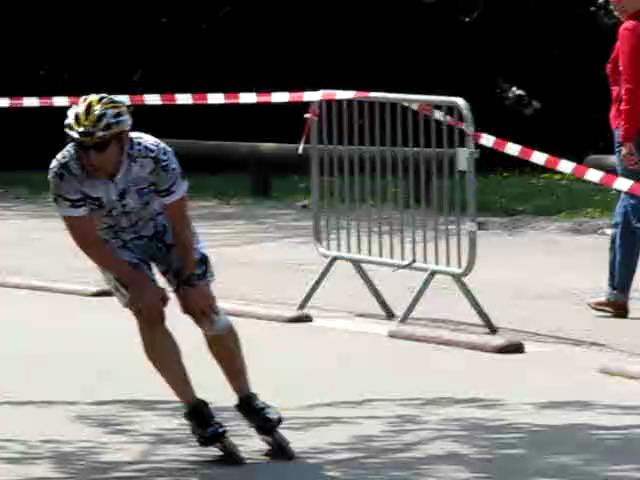
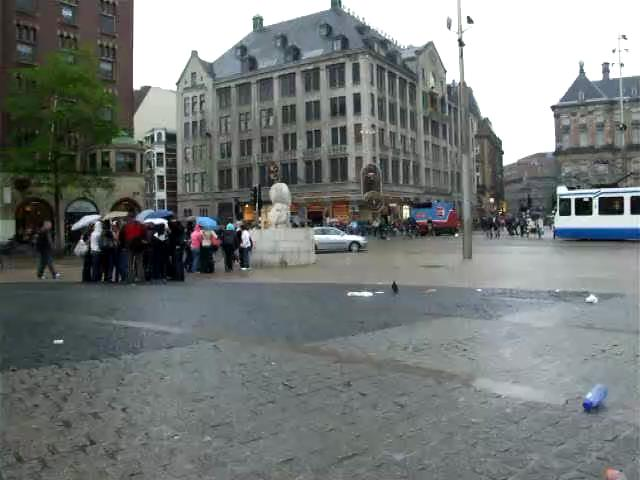
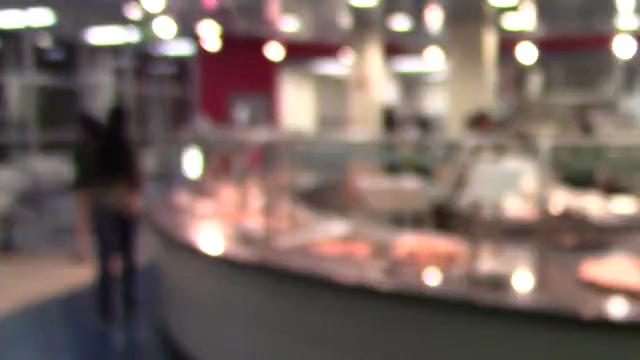

In [10]:
from pixeltable.functions.video import get_metadata

v.add_computed_column(video_metadata=get_metadata(v.video))
v.select(
    v.video, v.annotations, v.video_category, v.video_metadata
).head()

## Preannotations with Pixeltable and Label Studio

Frame extraction is another common operation in labeling workflows. In this example, we'll extract frames from our videos into a view, then use an object detection model to generate preannotations for each frame. The following code uses a Pixeltable `frame_iterator` to automatically extract frames into a new view, which we'll call `frames_2024_04_22`.

In [11]:
from datetime import datetime
from pixeltable.functions.video import frame_iterator

today = datetime(2024, 4, 22)
videos_table = pxt.get_table('ls_demo/videos')

# Create the view, using a `frame_iterator` to extract frames with a sample rate
# of `fps=0.25`, or 1 frame per 4 seconds of video. Setting `fps=0` would use the
# native framerate of the video, extracting every frame.

frames = pxt.create_view(
    'ls_demo/frames_2024_04_22',
    videos_table.where(videos_table.date == today),
    iterator=frame_iterator(videos_table.video, fps=0.25),
)

frame
""
""
""

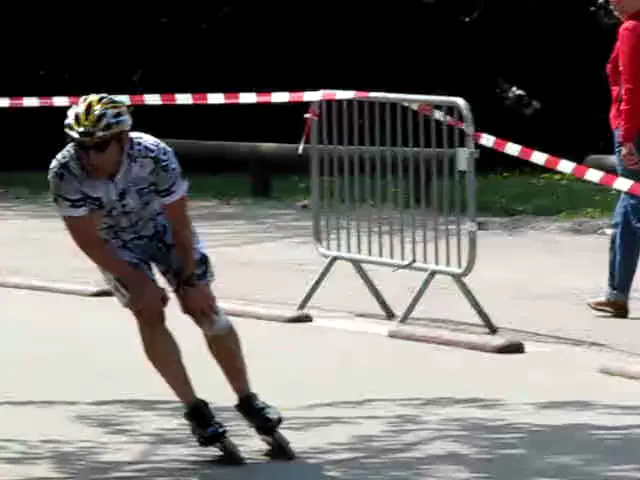
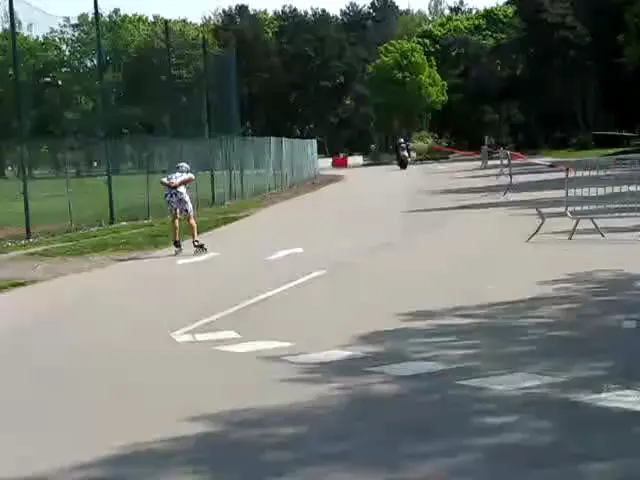
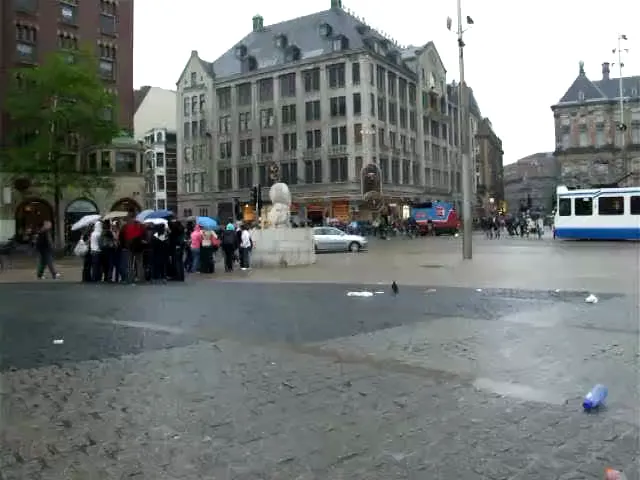

In [12]:
# Show just the first 3 frames in the table, to avoid cluttering the notebook

frames.select(frames.frame).head(3)

Now we'll use the Resnet-50 object detection model to generate preannotations. We do this by creating a new computed column.

Added 11 column values with 0 errors in 9.71 s (1.13 rows/s)


frame,detections
,"{""boxes"": [[584.916, 0.75, 639.989, 321.319], [46.766, 93.549, 294.693, 465.584]], ""labels"": [1, 1], ""scores"": [0.995, 0.999], ""label_text"": [""person"", ""person""]}"
,"{""boxes"": [[396.507, 137.014, 410.585, 164.346], [156.287, 162.72, 204.647, 255.222], [395.696, 143.705, 409.443, 170.493]], ""labels"": [1, 1, 4], ""scores"": [0.983, 1., 0.971], ""label_text"": [""person"", ""person"", ""motorcycle""]}"
,"{""boxes"": [[122.222, 217.602, 146.673, 283.292], [238.656, 224.618, 254.946, 270.926], [137.734, 209.832, 170.656, 220.507], [552.216, 185.434, 639.876, 241.177], [31.226, 219.263, 59.837, 280.576], [191.962, 216.052, 217.999, 226.336], [68.706, 214.707, 97.598, 228.479], [311.02, 226.593, 365.775, 253.306], [411.628, 200.023, 459.624, 234.31]], ""labels"": [1, 1, 28, 6, 1, 28, 28, 3, 6], ""scores"": [0.956, 0.991, 0.993, 0.998, 0.981, 0.994, 0.98, 0.999, 0.957], ""label_text"": [""person"", ""person"", ""umbrella"", ""bus"", ""person"", ""umbrella"", ""umbrella"", ""car"", ""bus""]}"

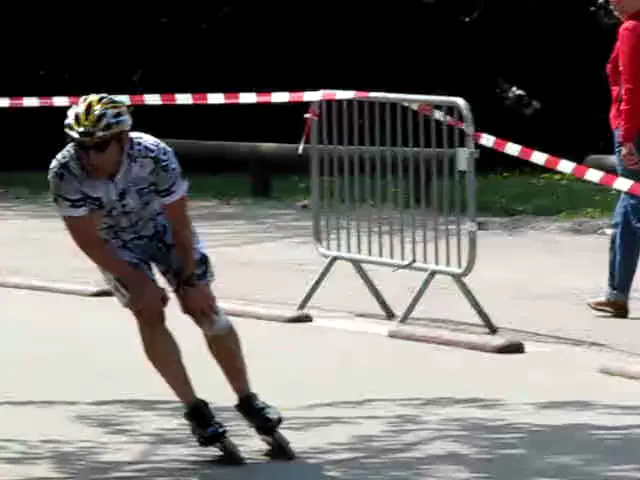
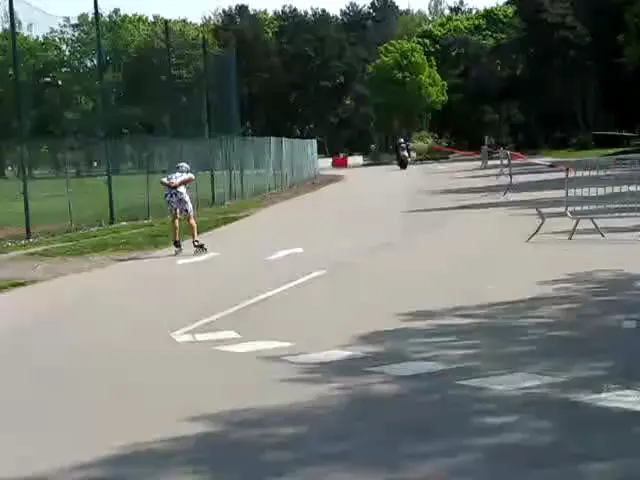
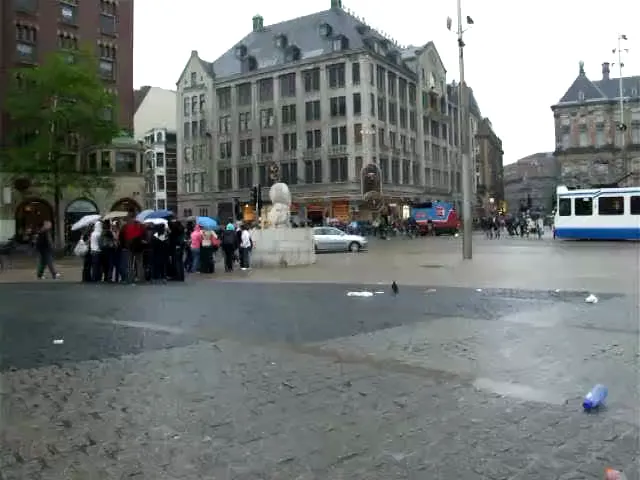

In [13]:
from pixeltable.functions.huggingface import detr_for_object_detection

# Run the Resnet-50 object detection model against each frame to generate bounding boxes
frames.add_computed_column(
    detections=detr_for_object_detection(
        frames.frame, model_id='facebook/detr-resnet-50', threshold=0.95
    )
)
frames.select(frames.frame, frames.detections).head(3)

We'd like to send these detections to Label Studio as preannotations, but they're not quite ready. Label Studio expects preannotations in standard COCO format, but the Huggingface library outputs them in its own custom format. We can use Pixeltable's handy `detr_to_coco` function to do the conversion, using another computed column.

In [ ]:
from pixeltable.functions.huggingface import detr_to_coco

frames.add_computed_column(
    preannotations=detr_to_coco(frames.frame, frames.detections)
)
frames.select(
    frames.frame, frames.detections, frames.preannotations
).head(3)

## Create a Label Studio Project for Frames

With our data workflow set up and the COCO preannotations prepared, all that's left is to create a corresponding Label Studio project. Note how Pixeltable automatically maps `RectangleLabels` preannotation fields to columns, just like it does with data fields. Here, Pixeltable interprets the `name="preannotations"` attribute in `RectangleLabels` to mean, "map these rectangle labels to the `preannotations` column in my linked table or view".

The Label values `car`, `person`, and `train` are standard COCO object identifiers used by many off-the-shelf object detection models. You can find the complete list of them here, and include as many as you wish: https://raw.githubusercontent.com/pixeltable/pixeltable/release/docs/resources/coco-categories.csv

In [ ]:
frames_config = """
    <View>
      <Image name="frame" value="$frame"/>
      <RectangleLabels name="preannotations" toName="frame">
        <Label value="car" background="blue"/>
        <Label value="person" background="red"/>
        <Label value="train" background="green"/>
      </RectangleLabels>
    </View>
    """

pxt.io.create_label_studio_project(frames, frames_config)

If you go into Label Studio and open up the new project, you can see the effect of adding the preannotations from Resnet-50 to our workflow.

## Incremental Updates

As we saw in the [10-Minute Tour](https://docs.pixeltable.com/overview/ten-minute-tour) tutorial, adding new data to Pixeltable results in incremental updates of everything downstream. We can see this by inserting a new video into our base videos table: all of the downstream views and computed columns are updated automatically, including the video metadata, frames, and preannotations.

The update may take some time, so please be patient (it involves a sequence of operations, including frame extraction and object detection).

In [ ]:
videos_table.insert(
    video=url_prefix + '22a/948/22a9487a92956ac453a9c15e0fc4dd4.mp4',
    date=today,
)

Note that the incremental updates do _not_ automatically sync the `Table` with the remote Label Studio projects. To issue a sync, we have to call the `sync()` methods separately. Note that tasks will be created only for the _newly added_ rows in the videos and frames views, not the existing ones.

In [ ]:
v.sync()
frames.sync()

## Deleting a Project

To remove a Label Studio project from a table or view, use `unlink_external_stores()`, as demonstrated by the following example. If you specify `delete_external_data=True`, then the Label Studio project will also be deleted, along with all existing data and annotations (be careful!) If `delete_external_data=False`, then the Label Studio project will be unlinked from Pixeltable, but the project and data will remain in Label Studio (so you'll need to delete the project manually if you later want to get rid of it).

In [ ]:
v.external_stores  # Get a list of all external stores for `v`

In [ ]:
v.unlink_external_stores('ls_project_0', delete_external_data=True)

## Configuring `media_import_method`

All of the examples so far in this tutorial use HTTP file uploads to send media data to Label Studio. This is the simplest method and the easiest to configure, but it's undesirable for complex projects or projects with a lot of data. In fact, the Label Studio documentation includes this specific warning: "Uploading data works fine for proof of concept projects, but it is not recommended for larger projects."

In Pixeltable, you can configure linked Label Studio projects to use URLs for media data (instead of file uploads) by specifying the `media_import_method='url'` argument in `create_label_studio_project`. This is recommended for all production applications, and is mandatory for projects whose input configuration is more complex than a single media file (in the Label Studio parlance, projects with more than one "data key").

If `media_import_method='url'`, then Pixeltable will simply pass the media data URLs directly to Label Studio. If the URLs are `http://` or `https://` URLs, then nothing more needs to be done.

Label Studio also supports `s3://` URLs with credentialed access. To use them, you'll need to configure access to your bucket in the project configuration. The simplest way to do this is by specifying an `s3_configuration` in `create_label_studio_project`. Here's an example, though it won't work directly in this demo notebook, since it relies on having an access key. (If your AWS credentials are stored in `~/.aws/credentials`, then you can omit the access key and secret, and Pixeltable will fill them in automatically.)

In [ ]:
pxt.io.create_label_studio_project(
    v,
    label_config,
    media_import_method='url',
    s3_configuration={
        'bucket': 'pxt-test',
        'aws_access_key_id': my_key,
        'aws_secret_access_key': my_secret,
    },
)

Before you can set up credentialed S3 access, you'll need to configure your S3 bucket to work with Label Studio; the details on how to do this are described here:

- [Label Studio Docs: Amazon S3](https://labelstud.io/guide/storage.html#Amazon-S3)

For the full documentation on `create_label_studio_project` usage, see:

- [Pixeltable SDK Docs: create_label_studio_project()](https://docs.pixeltable.com/sdk/latest/io#func-create-label-studio-project)

## Notebook Cleanup

That's the end of the tutorial! To conclude, let's terminate the running Label Studio process. (Of course, feel free to leave it running if you want to play around with it some more.)

In [ ]:
ls_process.kill()